<a href="https://colab.research.google.com/github/valerio-unifei/ECO904/blob/main/ECO904_2024_1_Atividade_2_Etapa_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset

Um conjunto de dados para classificação de doenças foliares de plantas de milho ou milho

**Descrição do conjunto de dados:**
0. Ferrugem Comum (Common Rust)- 1.306 imagens
1. Mancha Cinzenta na Folha (Gray Leaf Spot)- 574 imagens
2. Praga (Blight)- 1.146 imagens
3. Saudável (Healthy)- 1.162 imagens

**Observação:**

Este conjunto de dados foi feito usando os populares conjuntos de dados PlantVillage e PlantDoc . Durante a formação do conjunto de dados, foram removidas algumas imagens que não foram consideradas úteis. Os autores originais reservam-se o direito aos respectivos conjuntos de dados.

**Citações:**

- Singh D, Jain N, Jain P, Kayal P, Kumawat S, Batra N. PlantDoc: um conjunto de dados para detecção visual de doenças em plantas. Nos Anais do 7º ACM IKDD CoDS e 25º COMAD 2020, 5 de janeiro (pp. 249-253).
- J, ARUN PANDIAN; GOPAL, GEETHARAMANI (2019), “Dados para: Identificação de doenças foliares de plantas usando uma rede neural convolucional profunda de 9 camadas”, Mendeley Data, V1, doi: 10.17632/tywbtsjrjv.1

In [ ]:
import os
from google.colab import files, userdata

if not os.path.exists('/content/data'):
  if not os.path.exists('kaggle.json'):
    try:
      kaggle_key = userdata.get('kaggle_key')
      open('kaggle.json','w').write(kaggle_key)
    except:
      files.upload()

  !pip install -q kaggle

  !mkdir ~/.kaggle
  !cp kaggle.json ~/.kaggle/
  !rm kaggle.json
  !chmod 600 ~/.kaggle/kaggle.json
  !kaggle datasets download 'smaranjitghose/corn-or-maize-leaf-disease-dataset'
  !unzip -qq corn-or-maize-leaf-disease-dataset.zip
  !rm corn-or-maize-leaf-disease-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/smaranjitghose/corn-or-maize-leaf-disease-dataset
License(s): copyright-authors
100% 161M/161M [00:10<00:00, 21.8MB/s]
100% 161M/161M [00:10<00:00, 16.5MB/s]


Eliminando imagens com problemas

In [ ]:
num_skipped = 0
for folder_name in ('Blight', 'Common_Rust','Gray_Leaf_Spot','Healthy'):
    folder_path = os.path.join('/content/data/', folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print(f"Deleted {num_skipped} images.")

Deleted 75 images.


# Dataset em Tensor

In [ ]:
import keras

image_size = (180, 180)
batch_size = 32

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "/content/data/",
    validation_split=0.2,
    subset="both",
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical',
)

Found 4113 files belonging to 4 classes.
Using 3291 files for training.
Using 822 files for validation.


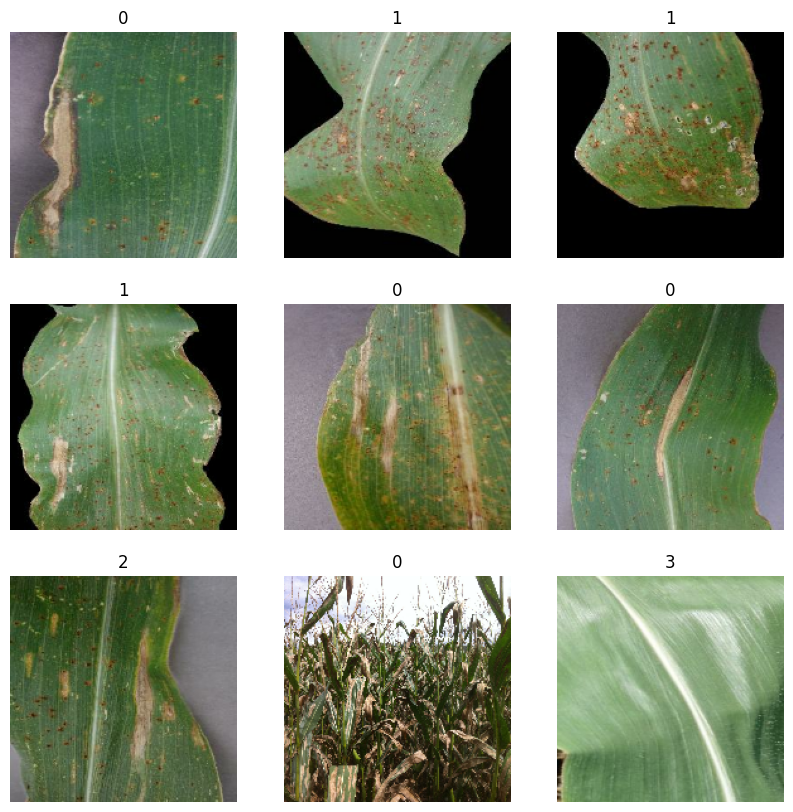

In [ ]:
# prompt: exiba as imagens com lables de 9 imagens de um lote

import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(np.argmax(labels[i]))
    plt.axis("off")

# Expandindo as imagens

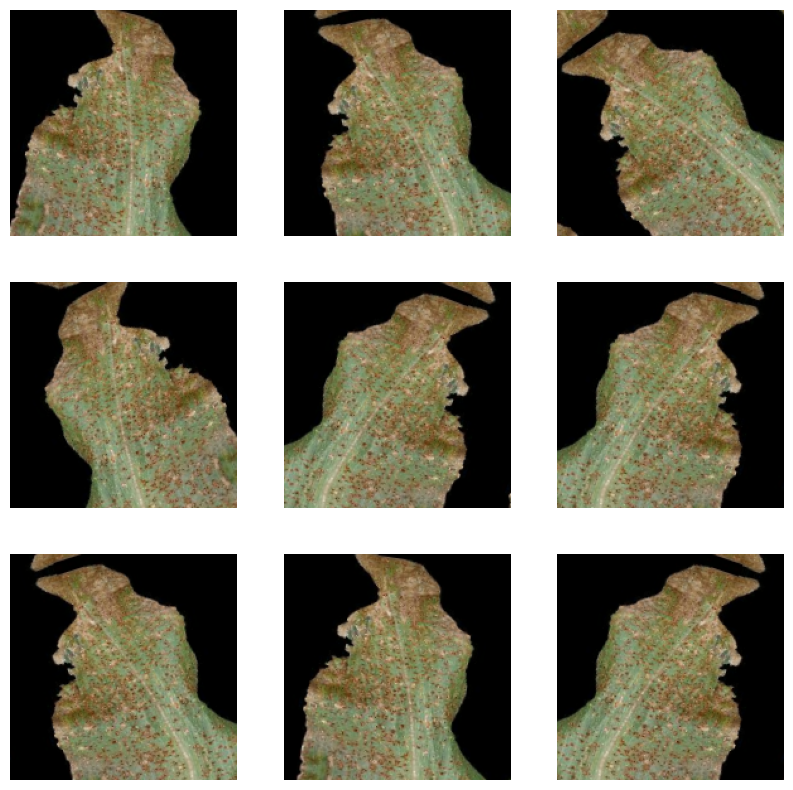

In [ ]:
from keras import layers

data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]

def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

#  Modelo de IA

In [ ]:

model = keras.Sequential([
    layers.Rescaling(1./255, input_shape=(image_size[0], image_size[1], 3)),
    layers.Conv2D(16, 3, activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(4)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 32)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 59168)             0

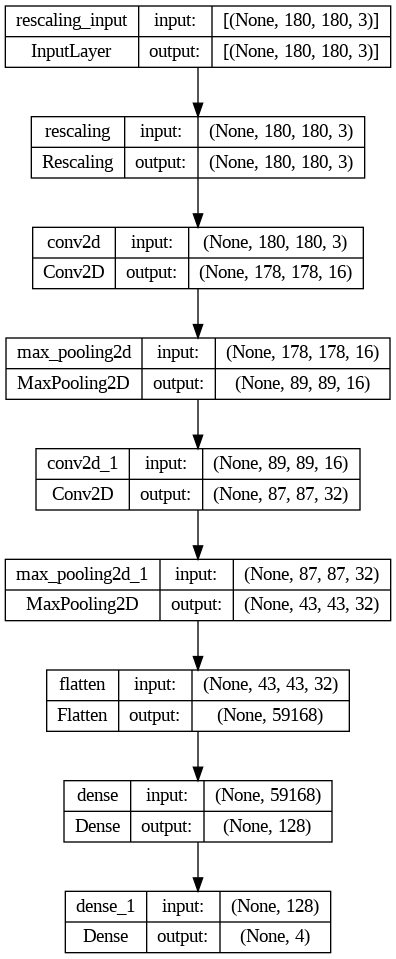

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

# Treinando Modelo

In [ ]:
from tensorflow import data as tf_data
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

historico = model.fit(train_ds, epochs=5, validation_data=val_ds)

Epoch 1/5
103/103 [==============================] - 18s 154ms/step - loss: 0.2966 - accuracy: 0.8733 - val_loss: 0.2907 - val_accuracy: 0.8832
Epoch 2/5
103/103 [==============================] - 18s 163ms/step - loss: 0.2663 - accuracy: 0.8867 - val_loss: 0.3134 - val_accuracy: 0.8516
Epoch 3/5
103/103 [==============================] - 21s 180ms/step - loss: 0.2596 - accuracy: 0.8912 - val_loss: 0.2553 - val_accuracy: 0.9100
Epoch 4/5
103/103 [==============================] - 20s 188ms/step - loss: 0.2307 - accuracy: 0.9025 - val_loss: 0.2678 - val_accuracy: 0.9039
Epoch 5/5
103/103 [==============================] - 23s 208ms/step - loss: 0.2435 - accuracy: 0.9022 - val_loss: 0.3130 - val_accuracy: 0.8479


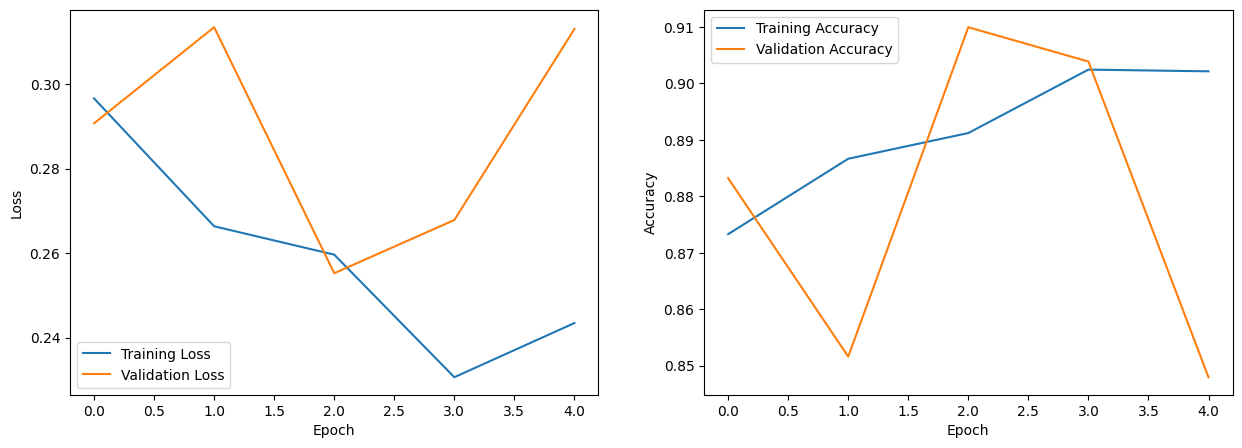

In [ ]:
loss = historico.history['loss']
val_loss = historico.history['val_loss']
accuracy = historico.history['accuracy']
val_accuracy = historico.history['val_accuracy']

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

26/26 [==============================] - 1s 32ms/step


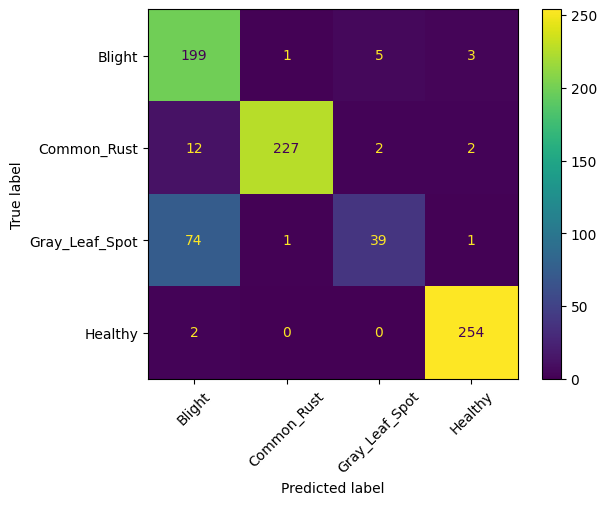

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = np.argmax(np.concatenate([y for x, y in val_ds], axis=0), axis=1)
y_pred = np.argmax(model.predict(val_ds), axis=1)

labels = ['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']
cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)

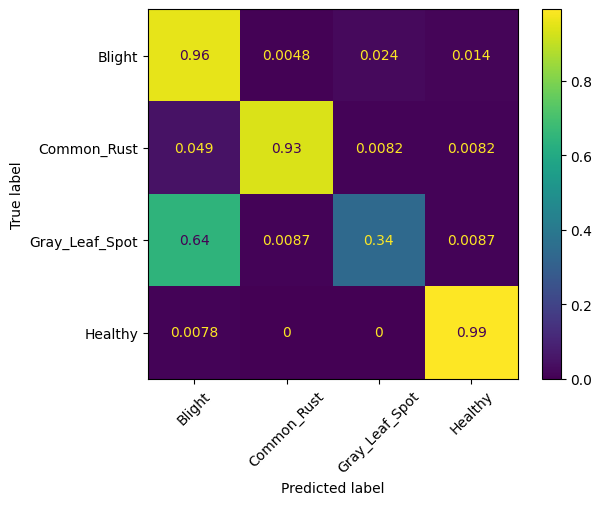

In [ ]:
cm = confusion_matrix(y_true, y_pred, normalize='true')

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)